### Sparkify Project Workspace

#### Overview

Sparkify is a music streaming service just as Spotify and Pandora.

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning.

We use F1 score to measure of model performance because we need precision and recall at the same time as we don't want to miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn.

We performed EDA to establish features, and train several machine learning classification models.

The model we built and selected has a F1 score of 0.800, which is 16% higher than sending everybody offers. There is also a short article about this project posted here.
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190724134603-0000
KERNEL_ID = c0d5b9a6-11c9-4856-9100-58c3097d8a56


In [132]:
# import libraries
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# import pyspark related libraries
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime as dt

## Load and Clean Dataset
In this project, the medium-dataset file  `mini_sparkify_event_data.json` is used. IBM-Watson cloud is used as a workspace for this project. 

In [3]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [6]:
# Read in full sparkify dataset

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ma7s7cezdcowaq'))
#df.persist()
df.take(2)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98')]

In [8]:
# Print schema for future reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Schema information

- artist: Artist name (ex. 'Martin Orford')
- auth: User authentication status (ex. 'Logged In')
- firstName: User first name (ex. 'Joseph')
- gender: Gender (ex. F or M)
- itemInSession: Item count in a session (ex. 20)
- lastName: User last name (ex. 'Morales')
- length: Length of song (ex. 597.55057)
- level: User plan (ex. 'free')
- location: User's location (ex. 'Corpus Christi, TX')
- method: HTTP method (ex. PUT)
- page: Page name (ex. 'NextSong')
- registration: Registration timestamp (unix timestamp) (ex. 1532063507000)
- sessionId: Session ID (ex. 292)
- song: Song (ex. 'Grand Designs')
- status: HTTP status (ex. 200)
- ts: Event timestamp(unix timestamp) (ex. 11538352011000)
- userAgent: User's browswer agent (ex. '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"')
- userId: User ID (ex. 293)

In [37]:
#Check the statstics of each columns using the describe function
for col in df.columns:
    print('---------------------')
    print(col)
    df.describe(col).show()
    print('\n')

---------------------
artist
+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772758|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



---------------------
auth
+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    543705|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+



---------------------
firstName
+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   528005|
|   mean|     null|
| stddev|     null|
|    min|  Aaliyah|
|    max|   Zyonna|
+-------+---------+



---------------------
gender
+-------+------+
|summary|gender|
+-------+------+
|  count|528005|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



---------------------
itemInSession
+-------+------------------+
|summary|     itemInSession|
+--

#### Deal with missing data

In [52]:
# check missing data
print("Percentage of missing data\n")

for col in df.columns:

    missing_count = df.filter((df[col].isNull()) | (df[col] == "")).count()*100 
    
    if missing_count > 0:
        print("{}: {:.2f} %".format(col, missing_count/df.count()))

Percentage of missing data

artist: 20.38 %
firstName: 2.89 %
gender: 2.89 %
lastName: 2.89 %
length: 20.38 %
location: 2.89 %
registration: 2.89 %
song: 20.38 %
userAgent: 2.89 %
userId: 2.89 %


In [51]:
# # clean missing value in userId and sessionId
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter((df["userId"].isNull()) | (df["userId"] != "")) # `userId` should not be empty string

print('After clean:')
print('Missing data in userId:',df_clean.filter(df_clean['userId'] == '').count())
print('Missing data in sessionId:',df_clean.filter(df_clean['sessionId'] == '').count())

After clean:
Missing data in userId: 0
Missing data in sessionId: 0


In [40]:
print("df:{}".format(df.count()))
print("df_clean: {}".format(df_clean.count())) # no missing values
print("\n{} rows are removed".format(df.count()-df_clean.count()))

df:543705
df_clean: 528005

15700 rows are removed


#### check data type

In [53]:
num_cols = []
cat_cols = []

for s in df_clean.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [54]:
print('numerical columns:',num_cols)
print('catagorical columns:', cat_cols)

numerical columns: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']
catagorical columns: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']


### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

The user whose page has "Cancellation Confirmation" is defined as a churned user in this analysis.

In [55]:
#df_clean_pd['page'].unique()
df_clean.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [56]:
df_clean.filter("page = 'Cancellation Confirmation'").show(3)
print(df_clean.filter("page = 'Cancellation Confirmation'").count())

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Olivia|     F|           40|    Carr|  null| free|      Fort Wayne, IN|   GET|Cancellation Conf...|1536758439000|      490|null|   200|1538400616000|Mozilla/5.0 (Wind...|   208|
|  null|Cancelled|  Lillian|     F|          234| Cameron|  null| paid|        Columbus, OH|   GET|Cancellation Conf...|1533472700000|      471|null|   200|1538482793000|Mozilla/5.0 (Wind...|   231|
|  nu

####  Create downgrade and chun label

In [57]:
# create downgrade label
downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("downgrade_event", downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
df_clean = df_clean.withColumn('downgrade', max('downgrade_event').over(windowval))

# create churn label
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_clean = df_clean.withColumn('churn', max('churn_event').over(windowval))

In [58]:
df_clean.select(["userId", "gender", "level", "churn",'downgrade']).dropDuplicates().show(10)

+------+------+-----+-----+---------+
|userId|gender|level|churn|downgrade|
+------+------+-----+-----+---------+
|100010|     F| free|    1|        0|
|200002|     M| free|    1|        0|
|200002|     M| paid|    1|        0|
|   296|     F| free|    1|        0|
|   296|     F| paid|    1|        0|
|   125|     M| free|    0|        0|
|   124|     F| paid|    1|        0|
|    51|     M| paid|    1|        0|
|     7|     M| free|    0|        0|
|200037|     M| free|    1|        0|
+------+------+-----+-----+---------+
only showing top 10 rows



In [30]:
# churned rate
churned_rate = df_clean.groupby("userId").agg({"churn": "sum"}).select(avg("sum(churn)")).collect()[0]["avg(sum(churn))"]
print("churned rate: {:.2f}%".format(churned_rate * 100))

churned rate: 23135.27%


#### timestamp

In [60]:
# add a time column to df
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn('event_time', convert_ts('ts'))
df_clean = df_clean.withColumn('registration_time', convert_ts('registration'))
df_clean.head(2)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, downgrade=0, churn_event=0, churn=1, event_time='2018-10-08 09:36:32', registration_time='2018-09-27 02:45:40'),
 Row(artist='Justice', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=285.41342, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Phantom Part 1.5 (Album Version)', status=200, ts=1538991618000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 l

In [63]:
df_clean.select(["userId", "page", "event_time", "level", "song", "sessionId"]).where(df.userId == "296").sort("event_time").show(10)

+------+--------+-------------------+-----+--------------------+---------+
|userId|    page|         event_time|level|                song|sessionId|
+------+--------+-------------------+-----+--------------------+---------+
|   296|NextSong|2018-10-02 10:55:51| free|Right Now (Radio ...|      463|
|   296|NextSong|2018-10-02 10:59:28| free|      Freddie's Dead|      463|
|   296|NextSong|2018-10-02 11:06:40| free|      Lonesome Loser|      463|
|   296|NextSong|2018-10-03 08:56:43| free|            Elegante|      631|
|   296|NextSong|2018-10-03 09:00:42| free|              Winner|      631|
|   296|NextSong|2018-10-03 09:04:46| free|        Last Of Days|      631|
|   296|NextSong|2018-10-03 09:08:58| free|               Angel|      631|
|   296|NextSong|2018-10-03 09:13:28| free|         L'Excessive|      631|
|   296|NextSong|2018-10-03 09:16:31| free|     Baby I'm A Fool|      631|
|   296|NextSong|2018-10-03 09:20:01| free|       Silver Lining|      631|
+------+--------+--------

#### Gender

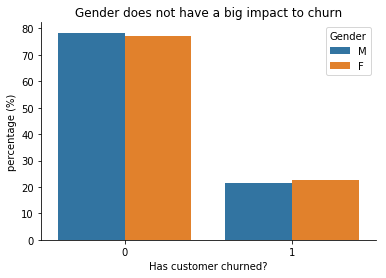

In [109]:
churn_gender = df_clean.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

F_sum = churn_gender[churn_gender['gender']=='F']['count'].sum()
M_sum = churn_gender[churn_gender['gender']=='M']['count'].sum()

p_M=pd.DataFrame({'percentage':churn_gender[churn_gender['gender']=='M']['count']/M_sum*100})
p_F=pd.DataFrame({'percentage':churn_gender[churn_gender['gender']=='F']['count']/F_sum*100})
       
pp = pd.concat([p_M, p_F], axis=0)
churn_gender = pd.concat([churn_gender, pp], axis=1)

ax = sns.barplot(x='churn', y='percentage', hue='gender', data=churn_gender)
plt.xlabel('Has customer churned?')
plt.ylabel('percentage (%)')
plt.legend(title='Gender', loc='best')
plt.title('Gender does not have a big impact to churn')
sns.despine(ax=ax);

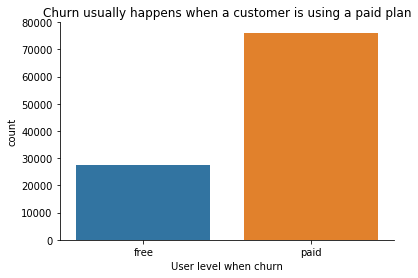

In [114]:
level_pd = df_clean.filter('churn == 1').groupby('level').count().toPandas()

ax = sns.barplot(data=level_pd, x='level', y='count')#, color=sns.color_palette()[0])
plt.xlabel('User level when churn')
plt.ylabel('count')
plt.title('Churn usually happens when a customer is using a paid plan')
sns.despine(ax=ax)


#### Page usage distribution between churn user and normal user

In [120]:
churn_count = df_clean.filter(df_clean['churn']==1).count()
no_churn_count = df_clean.filter(df_clean['churn']==0).count()

df_temp1 = df_clean.filter(df_clean['churn']==1).filter(df_clean['page']!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("churn", df_temp1["count"]/churn_count*100).sort("page")

df_temp2 = df_clean.filter(df_clean['churn']==0).filter(df_clean['page']!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("non_churn", df_temp2["count"]/no_churn_count*100).sort("page")

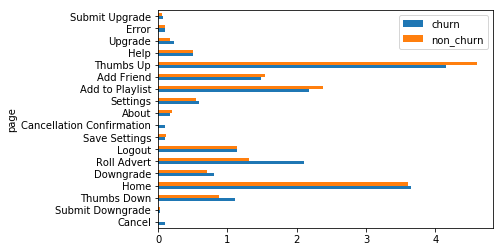

In [123]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.barh("page")

In [125]:
df_clean.select("event_time").describe().show()

+-------+-------------------+
|summary|         event_time|
+-------+-------------------+
|  count|             528005|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:00:11|
|    max|2018-12-01 00:01:06|
+-------+-------------------+



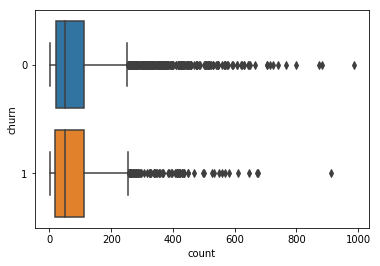

In [126]:
df_pd = df_clean.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)

In [137]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

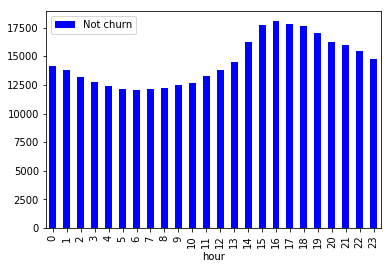

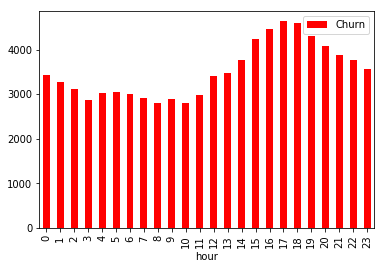

In [144]:
df_pd = df_clean.filter(df_clean.page == "NextSong").groupby("churn", 'hour').count().orderBy(df_clean['hour'].cast("float")).toPandas()
df_pd['hour'] = pd.to_numeric(df_pd['hour'])
df_pd[df_pd.churn==0].plot.bar(x='hour', y='count', color='Blue', label='Not churn')
df_pd[df_pd.churn==1].plot.bar(x='hour', y='count', color='Red', label='Churn')

In [ ]:
lt_pd = df_clean \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

In [ ]:
ax = sns.boxplot(data=lt_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
plt.title('Churned customer use the service for a shorter period of time')
sns.despine(ax=ax);


Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Feature Engineering¶
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

Write a script to extract the necessary features from the smaller subset of data
Ensure that your script is scalable, using the best practices discussed in Lesson 3
Try your script on the full data set, debugging your script if necessary
If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.